SESSION: Hyperparameters

<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G/blob/main/days/w1d2/hyperparameters/TP1_Ex1_Binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary classification problem

## The dataset

We study first a binary classification problem, performed by a neural network. Each input has two real features, that is, they are points in 2D and the output can be only 0 or 1.

The training set contains 4000 examples, and the validation set, 1000.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Display figures on jupyter notebook
%matplotlib inline

In [2]:
# Define a function to generate the dataset, in the form of two interlaced spirals
def spiral(phi):
    x = (phi + 1) * torch.cos(phi)
    y = phi * torch.sin(phi)
    return torch.cat((x, y), dim=1)


def generate_data(num_data):
    angles = torch.empty((num_data, 1)).uniform_(1, 15)
    data = spiral(angles)
    # add some noise to the data
    data += torch.empty((num_data, 2)).normal_(0.0, 0.4)
    labels = torch.zeros((num_data,), dtype=torch.int)
    # flip half of the points to create two classes
    data[num_data // 2 :, :] *= -1
    labels[num_data // 2 :] = 1
    return data, labels

In [4]:
# Generate the training set with 4000 examples
x_train, y_train = generate_data(4000)

print("X_train", x_train.shape)
print("y_train", y_train.shape)

X_train torch.Size([4000, 2])
y_train torch.Size([4000])


In [5]:
def plot_data(x, y):
    """Plot labeled data points X and y. Label 1 is a red +, label 0 is a blue +."""
    plt.figure(figsize=(5, 5))
    plt.plot(x[y == 1, 0], x[y == 1, 1], "r+")
    plt.plot(x[y == 0, 0], x[y == 0, 1], "b+")

We can now invoke the `plot_data` function on the dataset previously generated to see what it looks like:

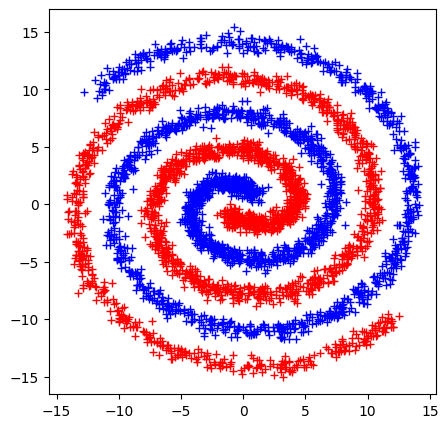

In [6]:
plot_data(x_train, y_train)

We use the `TensorDataset` wrapper from pytorch, so that the framework can easily understand our tensors as a proper dataset.

In [7]:
from torch.utils.data import TensorDataset, DataLoader

training_set = TensorDataset(x_train, y_train)

##  A neural network to classify the data

Here is a skeleton of a neural network with, by default, a single hidden layer. This is the model you'll try to improve during this exercise.

Look at the code and run it to see the structure, then follow the questions below to iteratively improve the model.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

At the first step, we define a neural network with just two layers. A useful tutorial for constructing model can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [24]:
from typing_extensions import Literal

class Model(nn.Module):
    """
    A fully connected neural network with any number of layers.
    """

    NAME_TO_NONLINEARITY = {
        "relu": nn.ReLU,
        "sigmoid": nn.Sigmoid,
        "tanh": nn.Tanh,
    }

    def __init__(
        self, layers=[2, 10, 1], non_linearity: Literal["relu", "sigmoid", "tanh"] = "relu"
    ):
        super(Model, self).__init__()

        modules = []
        for input_dim, output_dim in zip(layers[:-1], layers[1:]):
            modules.append(nn.Linear(input_dim, output_dim))
            # After each linear layer, we apply a non-linearity
            modules.append(self.NAME_TO_NONLINEARITY[non_linearity]())
            print("len(modules) = " + len(modules))

        # Remove the last non-linearity, since the last layer is the output layer
        self.layers = nn.Sequential(*modules[:-1])

    def forward(self, inputs):
        ouput = self.layers(inputs)

        # We want the model to predict 0 for one class and 1 for the other class
        # A Sigmoid activation function appropriate to map the output from [-inf, inf] to [0, 1]
        prediction = torch.sigmoid(ouput)
        return prediction

In [10]:
# Create the model:
model = Model()

# Choose the hyperparameters for training:
num_epochs = 40
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate (lr) of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Training the model
More information can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [11]:
# tqdm is a library used to display progress bars. It's extremely useful when training.
from tqdm.notebook import tqdm


def train(num_epochs: int, batch_size: int, criterion, optimizer, model, dataset, verbose: bool = False):
    """Train a model."""
    # Store the training errors
    train_losses = []
    # Create a DataLoader to iterate over the dataset in batches
    train_loader = DataLoader(dataset, batch_size, shuffle=True)

    for epoch in tqdm(range(num_epochs)):
        epoch_average_loss = 0
        # Each epoch, we iterate over the dataset once
        for x_batch, y_true in train_loader:
            # Compute the predictions.
            # Output shape is (batch_size, 1), so we squeeze the last dimension
            y_predicted = model(x_batch).squeeze(1)

            # The loss is how far the predictions are from the true labels
            loss = criterion(y_predicted, y_true.float())

            # Do gradient descent to minimize the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Record the average loss for this batch
            epoch_average_loss += loss.item() * batch_size / len(dataset)

        train_losses.append(epoch_average_loss)

        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_average_loss:.4f}")

    return train_losses

In [12]:
train_losses = train(num_epochs, batch_size, criterion, optimizer, model, training_set, 1)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1/40], Loss: 0.2520
Epoch [2/40], Loss: 0.2454
Epoch [3/40], Loss: 0.2449
Epoch [4/40], Loss: 0.2447
Epoch [5/40], Loss: 0.2444
Epoch [6/40], Loss: 0.2439
Epoch [7/40], Loss: 0.2436
Epoch [8/40], Loss: 0.2437
Epoch [9/40], Loss: 0.2432
Epoch [10/40], Loss: 0.2430
Epoch [11/40], Loss: 0.2429
Epoch [12/40], Loss: 0.2429
Epoch [13/40], Loss: 0.2425
Epoch [14/40], Loss: 0.2423
Epoch [15/40], Loss: 0.2423
Epoch [16/40], Loss: 0.2417
Epoch [17/40], Loss: 0.2417
Epoch [18/40], Loss: 0.2417
Epoch [19/40], Loss: 0.2410
Epoch [20/40], Loss: 0.2412
Epoch [21/40], Loss: 0.2410
Epoch [22/40], Loss: 0.2407
Epoch [23/40], Loss: 0.2406
Epoch [24/40], Loss: 0.2400
Epoch [25/40], Loss: 0.2400
Epoch [26/40], Loss: 0.2399
Epoch [27/40], Loss: 0.2393
Epoch [28/40], Loss: 0.2394
Epoch [29/40], Loss: 0.2391
Epoch [30/40], Loss: 0.2389
Epoch [31/40], Loss: 0.2386
Epoch [32/40], Loss: 0.2383
Epoch [33/40], Loss: 0.2378
Epoch [34/40], Loss: 0.2379
Epoch [35/40], Loss: 0.2373
Epoch [36/40], Loss: 0.2372
E

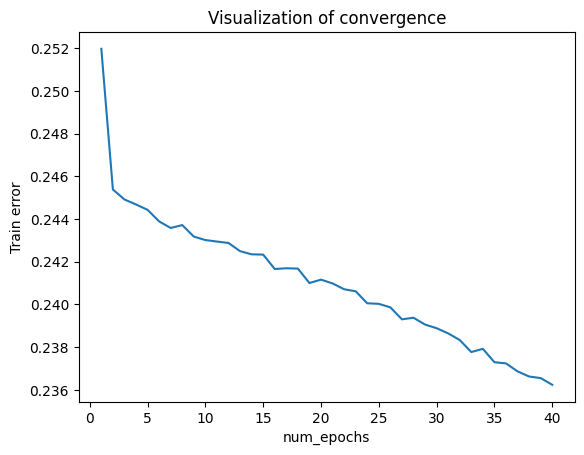

In [13]:
# Plot the training error wrt. the number of epochs
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

## Evaluating the model on the validation set

We first evaluate the accuracy on a validation set, to see how the model performs on unseen data.

In [14]:
# Generate 1000 validation datapoints
x_val, y_val = generate_data(1000)


def get_accuracy(model, x=x_val, y=y_val):
    """Compute the accuracy of the model on a dataset."""
    # Compute the predictions, without keeping track of the gradients
    with torch.no_grad():
        y_predicted = model(x).squeeze(1)

    # The predictions are in [0, 1] and the labels are either 0 or 1
    # So we round the predictions to get the predicted labels
    y_predicted = torch.round(y_predicted)

    # Compute the accuracy by counting the number of correct predictions
    accuracy = (y_predicted == y).sum().item() / len(y)

    print(f"Accuracy on {len(y)} examples: {accuracy:.2%}")
    return accuracy

In [15]:
get_accuracy(model);

Accuracy on 1000 examples: 59.90%


Then we visualize what the model has learned by plotting all the predictions.

In [16]:
def compare_predictions(model, x=x_val, y_real=y_val):
    """Compare the prediction with real labels."""

    with torch.no_grad():
        y_predicted = model(x).squeeze(1)

    plt.figure(figsize=(10, 5))

    reds = y_real > 0.5
    plt.subplot(121)
    plt.plot(x[reds, 0], x[reds, 1], "r+")
    plt.plot(x[~reds, 0], x[~reds, 1], "b+")
    plt.title("real data")

    reds = y_predicted > 0.5
    plt.subplot(122)
    plt.plot(x[reds, 0], x[reds, 1], "r+")
    plt.plot(x[~reds, 0], x[~reds, 1], "b+")
    plt.title("predicted data")

    plt.show()

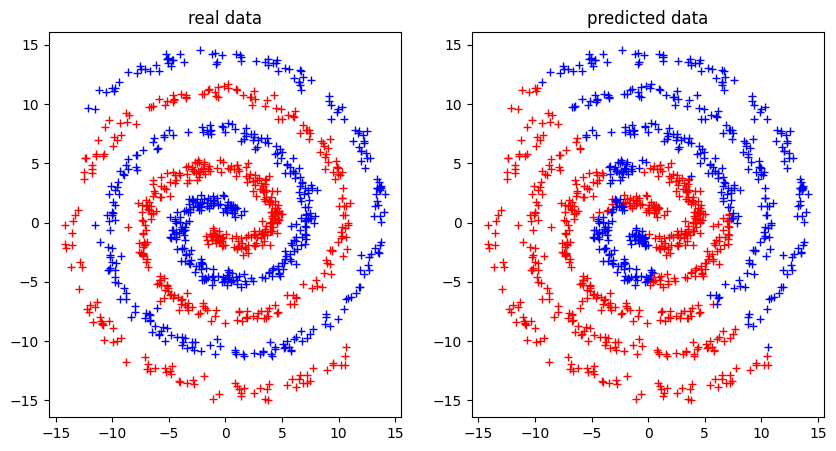

In [17]:
compare_predictions(model)

## Meta-optimisation

We defined a lot a hyper-parameters (learning rate, layer sizes...) in the previous section. We will now try to find the best combination of hyper-parameters.

> WARNING: For this exercise to be maximally useful, before you start answering the questions, try to make predictions about the impact of each meta-parameter.
Afterwards, you can check that the predictions were correct.

Bonus: if you want, you can make your predictions on [FateBook](https://fatebook.io).


Questions:
- Meta optimization: The goal of this tutorial is to get a summary table of the impact of each meta-parameter by clicking once on the "Run All" button.
To do this, you need to think about the difference between the grid search strategy and the sensitivity analysis strategy? Which strategy is more suitable in case there are a lot of meta parameters? Try to implement this strategy in the following.
- Why do you need the test dataset in addition to the validation dataset?

### Exercise 1: Impact of the architecture of the model

The class `Model` is the definition of your model.
Retrain the model by using different architectures, you can change them in the previous sections definition, or put everything you need in the cell below for convenience.

Try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try to different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons for each layer (5, 10, 20, more ?)


In [ ]:
## Add more layers
N_layers = 20

model = Model(layers=[2, N_layers, 1])
#     def __init__( self, layers=[2, 10, 1], non_linearity: Literal["relu", "sigmoid", "tanh"] = "relu" ):

# Choose the hyperparameters for training:
num_epochs = 40
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate (lr) of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_losses = train(num_epochs, batch_size, criterion, optimizer, model, training_set, 1)
# Plot the training error wrt. the number of epochs
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

get_accuracy(model)
compare_predictions(model)





In [ ]:
## Try to different activation functions sigmoid, tanh,relu
non_linearity = "relu" #["relu", "sigmoid", "tanh"]
#TODO

## Try to change the number of neurons for each layer (5, 10, 20, more ?)
#TODO

### Exercise 2: Impact of the optimizer

* Use different batch size from 10 to 400
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

In [ ]:
#TODO: the rest of the exercises starting here



### Exercise 3: Impact of the loss function

The current model uses a mean square error (MSE) loss. While this loss can be used in this case, it is now rarely used for classification, and instead a Binary Cross Entropy (BCE) is used. It consists in interpreting the output of the network as the probability $p(y | x)$ of the point $x$ to belong to the class $y$, and in maximizing the probability to be correct for all samples $x$, that is, in maximizing $\displaystyle \prod_{(x,y) \in Dataset} p(y|x)$. Applying $-\log$ to this quantity, we obtain the following criterion to minimize:

$$ \sum_{(x,y) \in Dataset} - \log p(y | x) $$

This is implemented as such by the [BCELoss](https://pytorch.org/docs/stable/nn.html?highlight=bce#torch.nn.BCELoss) of pytorch. Note that this criterion requires its input to be a probability, i.e. in $[0,1]$, which requires the use of an appropriate activation function beforehand, e.g., a sigmoid.

It turns out that, for numerical stability reasons, it is better to incorporate this sigmoid and the BCELoss into a single function; this is done by the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html?highlight=bcewithlogit#torch.nn.BCEWithLogitsLoss). Try to replace the MSE by this one and see how this changes the behavior in the network. This can also interact with the changes of the two previous exercices.

**Note:** As a consequence, when using the BCEWithLogitsLoss, the last layer of your network should not be followed by an activation function, as BCEWithLogitsLoss already adds a sigmoid.

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [26]:
#TODO: also check here: https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=50&networkShape=6,4,3,2,2&seed=0.33401&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=true&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

# OUTCOMES 

OURS
* more layers does not mean better train error but means better hyperparameter accuracy
* 

FROM TEACHERS  
* batch: heuristics to choose it: as many as fit in your GPU.   
* if you double the batch size you need to double the epochs. Why??  
* learning rate: common practice is have a lineral/exponential decreasing LR during the training  
* reasons to stop training: limit of compute budget, . The convergence is not necessarily a factor because the training loss might mean that we are overfitting
* train set: used only to train
* test set: only used once
* validation set: used for the hyperparameter tunning. You evaluate your training procedure on it. You can use it multiple times to tune your models. It can be that you over
  * does the validation set need to be a subset of the training set??
  * how do you choose the validation set??
* you could use a superset for the parameters and the hyperparameters and optimize on them. For this you usually need much more compute
* double descent: to check by myseld